# Discourse Relation Classification with mBERT (Natural Ordering)

Trains and evaluates `bert-base-multilingual-cased` on DISRPT 2025 Task 3 using **natural argument ordering**.  
All BERT model layers are first frozen, then only the top X% of encoder layers are unfrozen for fine-tuning (0%, 25%, 50%, 75%, or 100%), allowing controlled experiments on partial unfreezing.


**Task Info:** https://sites.google.com/view/disrpt2025/  
**Project Repo:** https://github.com/CLaC-Lab/DISRPT-2025  

**Author:** Nawar Turk



# 1. Setup


## 1.1. Environment & Seeds

In [ ]:
import os
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
from collections import Counter
import shutil
from google.colab import files
from transformers import EarlyStoppingCallback
import matplotlib.pyplot as plt
import random
import torch
from transformers import set_seed
from datasets import Dataset
from sklearn.metrics import classification_report

In [ ]:
SEED = 42

In [ ]:
def set_global_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TOKENIZERS_PARALLELISM'] = 'false'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    print(f"✅ Global seed set: {seed}")

set_global_seed(SEED)

✅ Global seed set: 42


## 1.2. Load Datasets

In [ ]:
# Load datasets from local or public paths
train_dataset = pd.read_csv('path/to/train_dataset.csv')
dev_dataset = pd.read_csv('path/to/dev_dataset.csv')

Mounted at /content/drive


# 2. Helper Functions

## 2.1. Plotting Function

In [ ]:
def plot_metrics_per_epoch(trainer):
    """Plot training loss, validation loss, and accuracy per epoch from a Trainer's log history."""

    log_history = trainer.state.log_history

    train_losses = []
    val_losses = []
    val_accuracies = []
    epochs = []

    for entry in log_history:
        if 'eval_loss' in entry:
            epoch = entry.get('epoch')
            eval_loss = entry['eval_loss']
            val_acc = entry.get('eval_accuracy')

            # Look for the training loss in the same or previous entry
            train_loss = None
            for e in reversed(log_history[:log_history.index(entry)+1]):
                if 'loss' in e and e.get('epoch') == epoch:
                    train_loss = e['loss']
                    break

            if epoch is not None and train_loss is not None:
                epochs.append(epoch)
                train_losses.append(train_loss)
                val_losses.append(eval_loss)
                val_accuracies.append(val_acc)

    # Plot with dual y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(epochs, train_losses, label="Train Loss", color="blue", marker='o')
    ax1.plot(epochs, val_losses, label="Val Loss", color="orange", marker='x')
    ax1.set_xticks(range(1, len(epochs) + 1))
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.set_ylim(0.0, 1.0)
    ax2.plot(epochs, val_accuracies, label="Val Accuracy", color="green", marker='s')
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc="upper right")

    # Find best epoch and accuracy
    best_idx = val_accuracies.index(max(val_accuracies))
    best_epoch = epochs[best_idx]
    best_acc = val_accuracies[best_idx]
    # Plot marker and label
    ax2.plot(best_epoch, best_acc, 'ro')  # red dot
    ax2.text(best_epoch, best_acc + 0.02, f'{best_acc:.2f}', color='red', ha='center')

    plt.title("Training vs Validation Loss and Accuracy per Epoch")
    plt.tight_layout()
    plt.show()

## 2.2. Training Function

In [ ]:

def train(model_name, train, dev, arg1_key, arg2_key, unfreeze_ratio):
  """
  Fine-tunes a transformer model for discourse relation classification with controlled layer freezing.

  This function:
  1. Converts train and dev datasets into DataFrames and encodes labels.
  2. Tokenizes text pairs (Arg1, Arg2) using the specified tokenizer.
  3. Loads a pretrained transformer for sequence classification.
  4. Freezes embeddings and a portion of encoder layers according to `unfreeze_ratio`.
  5. Trains the model with evaluation, early stopping, and metric tracking (accuracy, macro/micro F1).
  6. Saves:
    - Predictions with labels
    - Confusion matrix
    - Evaluation metrics
    - Fine-tuned model and tokenizer
  7. Prints:
    - Layer freezing summary
    - Accuracy/F1 scores overall, by language, and by framework
    - Classification report

  Args:
      model_name (str): Hugging Face model identifier.
      train (pd.DataFrame or list of dict): Training data with Arg1, Arg2, and label_text.
      dev (pd.DataFrame or list of dict): Development/validation data.
      arg1_key (str): Column name for the first argument text.
      arg2_key (str): Column name for the second argument text.
      unfreeze_ratio (float): Proportion of encoder layers to unfreeze (0.0 = all frozen, 1.0 = all unfrozen).

  Returns:
      tuple: (trainer, dev_with_predictions DataFrame)
  """

  # prepare_datasets_for_training
  train_df = pd.DataFrame(train)
  dev_df = pd.DataFrame(dev)

  unique_labels = sorted(train_df['label_text'].unique())
  label2id = {label: i for i, label in enumerate(unique_labels)}
  id2label = {i: label for i, label in enumerate(unique_labels)}

  train_df['label'] = train_df['label_text'].map(label2id)
  dev_df['label'] = dev_df['label_text'].map(label2id)

  # Tokenization function
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  def tokenize(examples):
    return tokenizer(
        examples[arg1_key],
        examples[arg2_key],
        truncation=True,
        padding=True,
        max_length=512
        )
  train_dataset = Dataset.from_pandas(train_df)
  dev_dataset = Dataset.from_pandas(dev_df)
  train_dataset = train_dataset.map(tokenize, batched=True)
  dev_dataset = dev_dataset.map(tokenize, batched=True)

  # Load a model
  model = AutoModelForSequenceClassification.from_pretrained(
  model_name,
  num_labels=len(unique_labels),
  id2label=id2label,
  label2id=label2id
  )

  output_dir = f"./{model_name.replace('/', '-')}-discourse-OD-{arg1_key}"

  # Freeze embeddings always
  if hasattr(model.base_model, 'embeddings'):
    for param in model.base_model.embeddings.parameters():
      param.requires_grad = False
  else:
    print("⚠️ Could not apply embedding freezing. Unexpected model structure.")

  # Freeze encoder layers based on unfreeze_ratio
  if hasattr(model.base_model, 'encoder') and hasattr(model.base_model.encoder, 'layer'):
    total_layers = len(model.base_model.encoder.layer)
    unfreeze_start = int((1 - unfreeze_ratio) * total_layers)

    for i, layer in enumerate(model.base_model.encoder.layer):
      requires_grad = i >= unfreeze_start
      for param in layer.parameters():
        param.requires_grad = requires_grad

    print(f"*_Total encoder layers: {total_layers}")
    if unfreeze_ratio > 0:
      print(f"*_Unfreezing from layer {unfreeze_start} to {total_layers - 1}")
    else:
      print("*_All layers frozen")
  else:
    print("⚠️ Could not apply encoder layer freezing. Unexpected model structure.")

  def print_trainable_parameters(model):
    from collections import defaultdict
    grouped = defaultdict(list)


    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"*_Total parameters:     {total:,}")
    print(f"*__Trainable parameters: {trainable:,}")
    print(f"*__Trainable ratio:      {100 * trainable / total:.2f}%")

    for name, param in model.named_parameters():
      if param.requires_grad:
        # top_group = '.'.join(name.split('.')[:4]) if 'bert.encoder.layer' in name else '.'.join(name.split('.')[:2])
        if 'roberta.encoder.layer' in name or 'bert.encoder.layer' in name or 'deberta.encoder.layer' in name:
          top_group = '.'.join(name.split('.')[:4])  # up to the layer index
        else:
          top_group = '.'.join(name.split('.')[:2])
        grouped[top_group].append(name)

    for group, names in sorted(grouped.items()):
      print(f"✅ {group}: ({len(names)} params)")

  print_trainable_parameters(model)

  training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    num_train_epochs=20,
    weight_decay=0.01,
    warmup_ratio=0.1,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=3,
    seed=SEED,
    data_seed=SEED,
    dataloader_num_workers=0,  # deterministic
    fp16=True
    )

  def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    return {"accuracy": accuracy, "f1_macro": f1_macro, "f1_micro": f1_micro}

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=dev_dataset,
      processing_class=tokenizer,
      compute_metrics=compute_metrics,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
  )

  trainer.train()

  predictions = trainer.predict(dev_dataset)
  preds = np.argmax(predictions.predictions, axis=-1)

  # Convert to DataFrame and add predictions
  dev_with_predictions = dev_dataset.to_pandas().reset_index(drop=True)
  dev_with_predictions['pred_label_id'] = preds
  dev_with_predictions['pred_label'] = dev_with_predictions['pred_label_id'].map(id2label)

  # Create confusion matrix
  confusion_matrix = pd.crosstab(
      dev_with_predictions['label_text'],
      dev_with_predictions['pred_label'],
      margins=False  # No totals for averaging
  )

  # Save as CSV
  filename = f"confusion_matrix_{arg1_key}{model_name.replace('/','-')}-{unfreeze_ratio}.csv"
  confusion_matrix.to_csv(filename)
  print(f"Saved: {filename}")

  true_labels = dev_with_predictions['label_text'].values
  pred_labels = dev_with_predictions['pred_label'].values

  # Save CSV
  predictions_file = f"predictions_{model_name.replace('/','-')}_{arg1_key}-{unfreeze_ratio}.csv"
  dev_with_predictions.to_csv(predictions_file, index=False)
  print(f"💾 Saved predictions to: {predictions_file}")

  # Calculate comprehensive metrics using sklearn
  accuracy = accuracy_score(true_labels, pred_labels)
  f1_macro = f1_score(true_labels, pred_labels, average='macro')
  f1_micro = f1_score(true_labels, pred_labels, average='micro')
  f1_weighted = f1_score(true_labels, pred_labels, average='weighted')

  print(f"📊 {model_name.upper()} on DEV RESULTS:")
  print(f"   Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
  print(f"   F1-Macro:    {f1_macro:.4f}")
  print(f"   F1-Micro:    {f1_micro:.4f}")
  print(f"   F1-Weighted: {f1_weighted:.4f}")

  # Optional: Print detailed classification report
  if len(id2label) <= 20:
      print(f"\n📋 Classification Report:")
      target_names = [id2label[i] for i in sorted(id2label.keys())]
      print(classification_report(true_labels, pred_labels,
                                target_names=target_names,
                                digits=4, zero_division=0))

  def lang_accuracy(data):
   languages = data['lang'].unique()
   for lang in languages:
       lang_data = data[data['lang']==lang]
       lang_acc = (lang_data['label_text'] == lang_data['pred_label']).mean().round(3)
       print(f"{lang}: {lang_acc*100:.1f}%")

  def framework_accuracy(data):
    frameworks = data['framework'].unique()
    for fw in frameworks:
        fw_data = data[data['framework']==fw]
        fw_acc = (fw_data['label_text'] == fw_data['pred_label']).mean().round(3)
        print(f"{fw}: {fw_acc*100:.1f}%")

  lang_accuracy(dev_with_predictions)
  framework_accuracy(dev_with_predictions)

  # Save Model
  save_path = f"./{model_name.replace('/', '-')}-discourse-final-{arg1_key}-{unfreeze_ratio}"
  trainer.save_model(save_path)
  trainer.tokenizer.save_pretrained(save_path)
  zip_path = shutil.make_archive(save_path, 'zip', save_path)

  return trainer, dev_with_predictions

# 3. Experiments

In [ ]:
model_name = "bert-base-multilingual-cased"
arg1_key = 'unordered_arg1'
arg2_key = 'unordered_arg2'

## 3.1. Unfreeze 0%

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/169284 [00:00<?, ? examples/s]

Map:   0%|          | 0/27566 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*_Total encoder layers: 12
*_All layers frozen
*_Total parameters:     177,866,513
*__Trainable parameters: 603,665
*__Trainable ratio:      0.34%
✅ bert.pooler: (2 params)
✅ classifier.bias: (1 params)
✅ classifier.weight: (1 params)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,2.441300,2.212184,0.350069,0.106335,0.350069
2,2.040300,1.825897,0.432453,0.235579,0.432453
3,1.796700,1.673384,0.472031,0.304170,0.472031
4,1.712100,1.612106,0.494413,0.358308,0.494413
5,1.669700,1.577409,0.504172,0.397651,0.504172
6,1.644500,1.554023,0.513640,0.413990,0.513640
7,1.626200,1.538325,0.517340,0.424611,0.517340
8,1.615400,1.527772,0.519481,0.436096,0.519481
9,1.605300,1.518336,0.523398,0.446368,0.523398
10,1.600100,1.508837,0.525248,0.447379,0.525248


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

Saved: confusion_matrix_unordered_arg1bert-base-multilingual-cased-0.csv
💾 Saved predictions to: predictions_bert-base-multilingual-cased_unordered_arg1-0.csv
📊 BERT-BASE-MULTILINGUAL-CASED on DEV RESULTS:
   Accuracy:    0.5338 (53.38%)
   F1-Macro:    0.4716
   F1-Micro:    0.5338
   F1-Weighted: 0.5156

📋 Classification Report:
               precision    recall  f1-score   support

  alternation     0.8514    0.3247    0.4701       194
  attribution     0.7423    0.8126    0.7759       886
       causal     0.4819    0.5376    0.5082      2924
      comment     0.3482    0.2207    0.2701       920
   concession     0.5155    0.4374    0.4732      1294
    condition     0.5584    0.4986    0.5268       738
  conjunction     0.4909    0.6070    0.5428      4555
     contrast     0.4814    0.2376    0.3182      1254
  elaboration     0.5259    0.6739    0.5907      6412
  explanation     0.4142    0.1206    0.1869      1061
        frame     0.5673    0.1957    0.2910       797
      

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


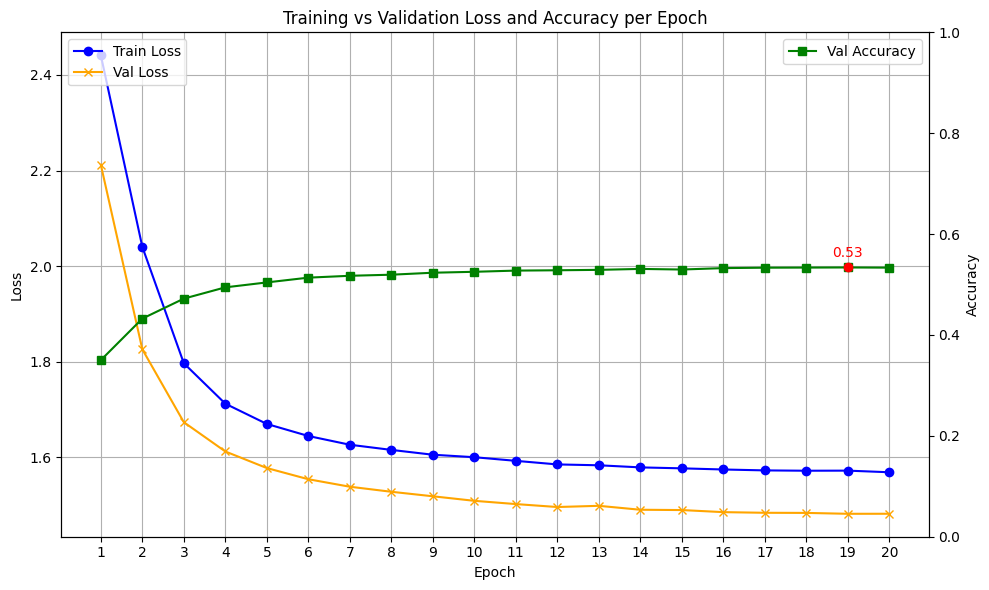

In [ ]:
trainer, dev_with_predictions = train(model_name, train_dataset, dev_dataset, arg1_key, arg2_key, unfreeze_ratio=0)
plot_metrics_per_epoch(trainer)

## 3.2. Unfreeze Top 25%

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/169284 [00:00<?, ? examples/s]

Map:   0%|          | 0/27566 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*_Total encoder layers: 12
*_Unfreezing from layer 9 to 11
*_Total parameters:     177,866,513
*__Trainable parameters: 21,867,281
*__Trainable ratio:      12.29%
✅ bert.encoder.layer.10: (16 params)
✅ bert.encoder.layer.11: (16 params)
✅ bert.encoder.layer.9: (16 params)
✅ bert.pooler: (2 params)
✅ classifier.bias: (1 params)
✅ classifier.weight: (1 params)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,1.788700,1.308174,0.591054,0.533786,0.591054
2,1.252500,1.192681,0.621817,0.591703,0.621817
3,1.127000,1.133642,0.634332,0.610018,0.634332
4,1.025500,1.133385,0.640028,0.615929,0.640028
5,0.936200,1.157272,0.637162,0.613471,0.637162
6,0.851100,1.175187,0.638359,0.612158,0.638359
7,0.770200,1.227774,0.633607,0.613401,0.633607


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

Saved: confusion_matrix_unordered_arg1bert-base-multilingual-cased-0.25.csv
💾 Saved predictions to: predictions_bert-base-multilingual-cased_unordered_arg1-0.25.csv
📊 BERT-BASE-MULTILINGUAL-CASED on DEV RESULTS:
   Accuracy:    0.6400 (64.00%)
   F1-Macro:    0.6159
   F1-Micro:    0.6400
   F1-Weighted: 0.6346

📋 Classification Report:
               precision    recall  f1-score   support

  alternation     0.7647    0.6031    0.6744       194
  attribution     0.8359    0.9199    0.8759       886
       causal     0.7269    0.5906    0.6517      2924
      comment     0.4695    0.4022    0.4333       920
   concession     0.6354    0.5657    0.5985      1294
    condition     0.6703    0.7520    0.7088       738
  conjunction     0.5662    0.6753    0.6159      4555
     contrast     0.5685    0.4601    0.5086      1254
  elaboration     0.6411    0.7023    0.6703      6412
  explanation     0.4116    0.2941    0.3430      1061
        frame     0.6299    0.4015    0.4904       797


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


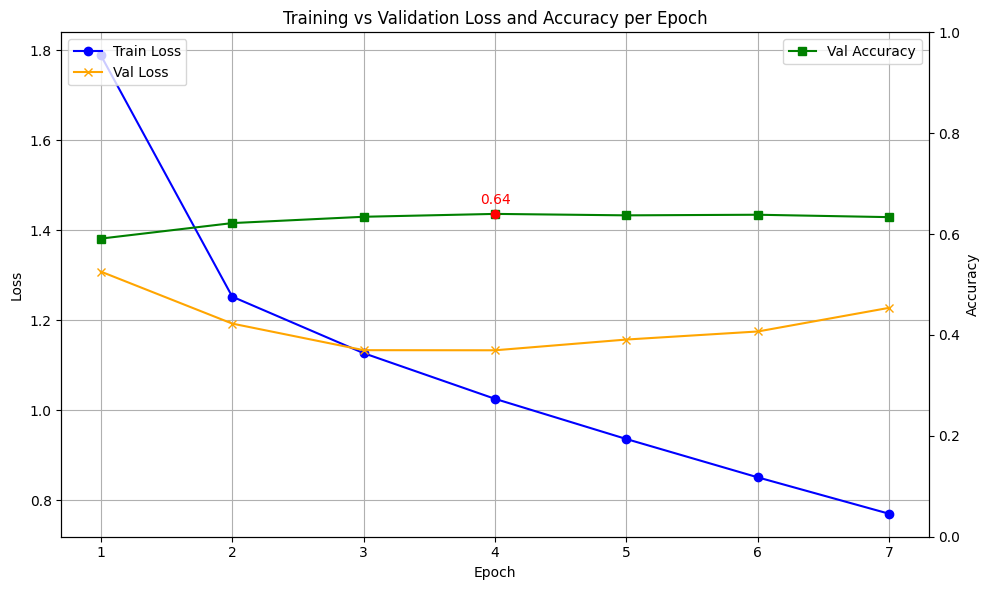

In [ ]:
trainer, dev_with_predictions = train(model_name, train_dataset, dev_dataset, arg1_key, arg2_key, unfreeze_ratio=0.25)
plot_metrics_per_epoch(trainer)



---



## 3.3. Unfreeze Top 50%

Map:   0%|          | 0/169284 [00:00<?, ? examples/s]

Map:   0%|          | 0/27566 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*_Total encoder layers: 12
*_Unfreezing from layer 6 to 11
*_Total parameters:     177,866,513
*__Trainable parameters: 43,130,897
*__Trainable ratio:      24.25%
✅ bert.encoder.layer.10: (16 params)
✅ bert.encoder.layer.11: (16 params)
✅ bert.encoder.layer.6: (16 params)
✅ bert.encoder.layer.7: (16 params)
✅ bert.encoder.layer.8: (16 params)
✅ bert.encoder.layer.9: (16 params)
✅ bert.pooler: (2 params)
✅ classifier.bias: (1 params)
✅ classifier.weight: (1 params)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,1.696200,1.246903,0.608322,0.563237,0.608322
2,1.183400,1.169165,0.634332,0.601092,0.634332
3,1.045200,1.111276,0.640789,0.614566,0.640789
4,0.909200,1.137192,0.643329,0.622271,0.643329
5,0.780600,1.208941,0.642712,0.617964,0.642712
6,0.661700,1.278966,0.637452,0.616423,0.637452


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

Saved: confusion_matrix_unordered_arg1bert-base-multilingual-cased-0.5.csv
💾 Saved predictions to: predictions_bert-base-multilingual-cased_unordered_arg1-0.5.csv
📊 BERT-BASE-MULTILINGUAL-CASED on DEV RESULTS:
   Accuracy:    0.6408 (64.08%)
   F1-Macro:    0.6146
   F1-Micro:    0.6408
   F1-Weighted: 0.6363

📋 Classification Report:
               precision    recall  f1-score   support

  alternation     0.8699    0.5515    0.6751       194
  attribution     0.8697    0.9187    0.8935       886
       causal     0.7132    0.5886    0.6449      2924
      comment     0.5073    0.4152    0.4567       920
   concession     0.6205    0.5951    0.6075      1294
    condition     0.7829    0.6938    0.7356       738
  conjunction     0.5412    0.7212    0.6184      4555
     contrast     0.5483    0.4705    0.5064      1254
  elaboration     0.6441    0.7146    0.6775      6412
  explanation     0.5370    0.2601    0.3505      1061
        frame     0.5235    0.4329    0.4739       797
  

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


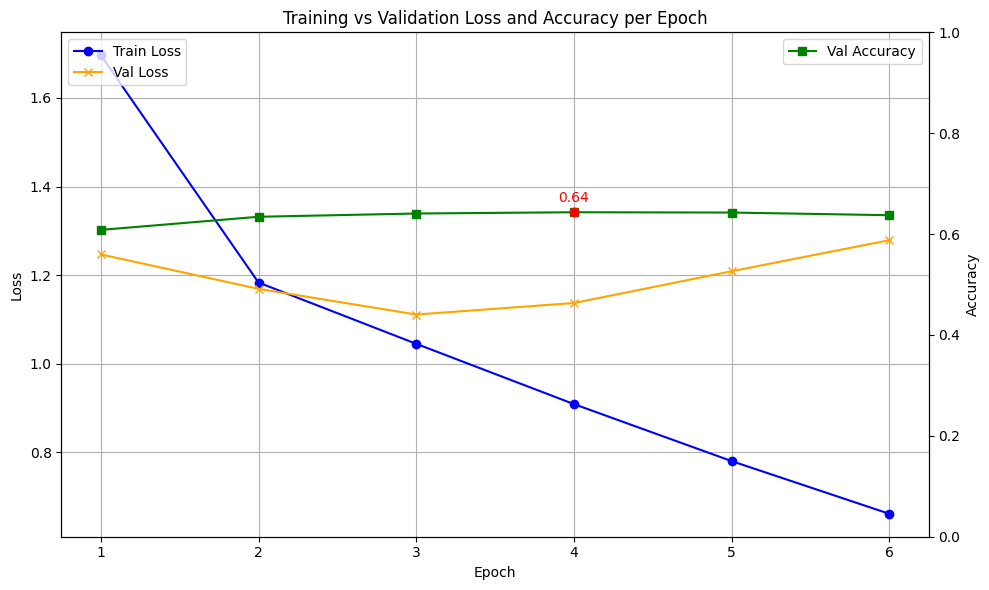

In [ ]:
trainer, dev_with_predictions = train(model_name, train_dataset, dev_dataset, arg1_key, arg2_key, unfreeze_ratio=0.5)
plot_metrics_per_epoch(trainer)

## 3.4. Unfreeze Top 75%

Map:   0%|          | 0/169284 [00:00<?, ? examples/s]

Map:   0%|          | 0/27566 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*_Total encoder layers: 12
*_Unfreezing from layer 3 to 11
*_Total parameters:     177,866,513
*__Trainable parameters: 64,394,513
*__Trainable ratio:      36.20%
✅ bert.encoder.layer.10: (16 params)
✅ bert.encoder.layer.11: (16 params)
✅ bert.encoder.layer.3: (16 params)
✅ bert.encoder.layer.4: (16 params)
✅ bert.encoder.layer.5: (16 params)
✅ bert.encoder.layer.6: (16 params)
✅ bert.encoder.layer.7: (16 params)
✅ bert.encoder.layer.8: (16 params)
✅ bert.encoder.layer.9: (16 params)
✅ bert.pooler: (2 params)
✅ classifier.bias: (1 params)
✅ classifier.weight: (1 params)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,1.680900,1.219872,0.616629,0.575737,0.616629
2,1.153800,1.160096,0.637815,0.608383,0.637815
3,1.008500,1.115431,0.643039,0.619632,0.643039
4,0.851700,1.148230,0.648226,0.625355,0.648226
5,0.706200,1.257194,0.641479,0.619154,0.641479
6,0.579900,1.335111,0.632446,0.614260,0.632446


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

Saved: confusion_matrix_unordered_arg1bert-base-multilingual-cased-0.75.csv
💾 Saved predictions to: predictions_bert-base-multilingual-cased_unordered_arg1-0.75.csv
📊 BERT-BASE-MULTILINGUAL-CASED on DEV RESULTS:
   Accuracy:    0.6430 (64.30%)
   F1-Macro:    0.6196
   F1-Micro:    0.6430
   F1-Weighted: 0.6382

📋 Classification Report:
               precision    recall  f1-score   support

  alternation     0.8672    0.5722    0.6894       194
  attribution     0.8731    0.9244    0.8980       886
       causal     0.7262    0.5732    0.6407      2924
      comment     0.4891    0.4130    0.4478       920
   concession     0.6193    0.6036    0.6114      1294
    condition     0.7824    0.7114    0.7452       738
  conjunction     0.5402    0.7155    0.6156      4555
     contrast     0.6281    0.4242    0.5064      1254
  elaboration     0.6393    0.7135    0.6744      6412
  explanation     0.5034    0.2799    0.3598      1061
        frame     0.5528    0.3940    0.4601       797


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


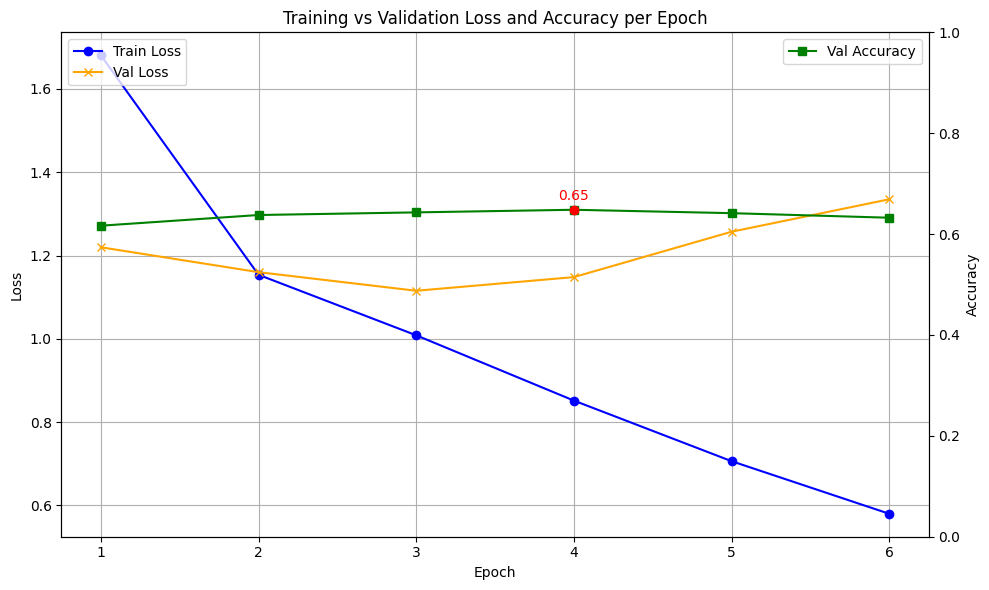

In [ ]:
trainer, dev_with_predictions = train(model_name, train_dataset, dev_dataset, arg1_key, arg2_key, unfreeze_ratio=0.75)
plot_metrics_per_epoch(trainer)